# Assessing confidence in cell2fate predictions

In this notebook we show how to use cell2fate's Bayesian posterior estimates of cell specific time to assess the confidence in cell state transition estimates.

In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'HumanBoneMarrow'

2024-05-13 14:35:56.729405: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 14:35:57.908886: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 14:36:01.420220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 14:36:01.420320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 14:36:01.809981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/HumanBoneMarrow/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/HumanBoneMarrow/'

In [3]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

Load the data and extract most variable genes (and optionally remove some clusters).

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 7837 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [5]:
max_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.
Number of Leiden Clusters: 11
Maximal Number of Modules: 12


Overview of the dataset on a UMAP, coloured by cluster assingment.

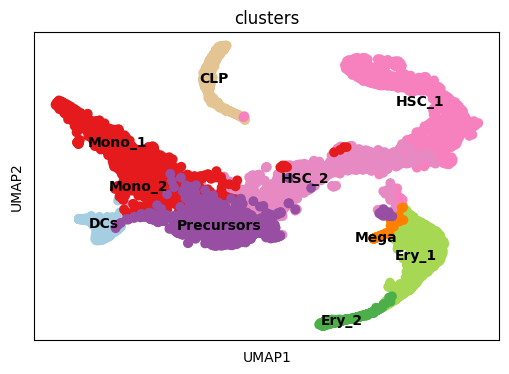

In [6]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [7]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


... and initialize the model:

In [8]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = max_modules)

Let's have a look at the anndata setup:

In [9]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 5780  │
│      n_vars      │ 3000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [10]:
mod.train(max_epochs = 500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████| 500/500 [06:31<00:00,  1.28it/s, v_num=1, elbo_train=1.61e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

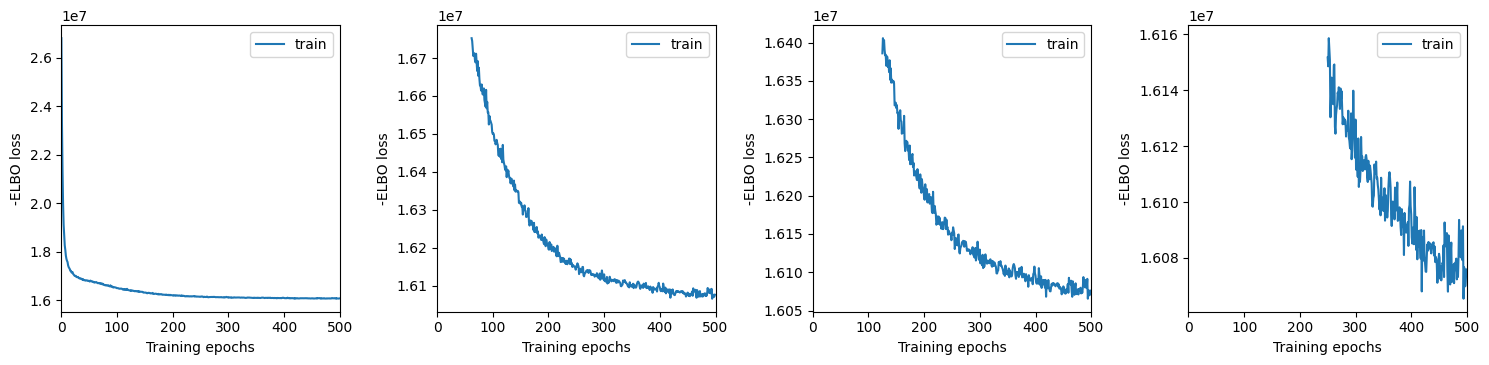

In [11]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [12]:
adata = mod.export_posterior(adata)

Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


We make the usual visualization of total RNAvelocity on a UMAP:

Computing total RNAvelocity ...


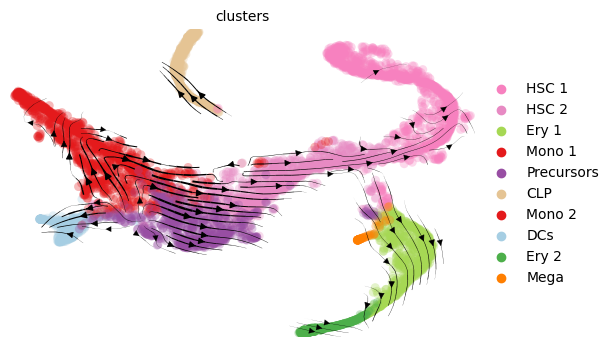

In [14]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

Since RNA velocity projections on a UMAP plot can be misleading, here we also calculate differences in median time across clusters involved in transitions:

In [15]:
chosen_transitions = [('HSC_1', 'Ery_1'),('Ery_1', 'Ery_2'),('HSC_1', 'HSC_2')]
c2f.utils.compute_transition_times(adata, chosen_transitions)

,Transition,Time Difference
0,"(HSC_1, Ery_1)",28.84515
1,"(Ery_1, Ery_2)",17.710777
2,"(HSC_1, HSC_2)",-11.335499


To assess the confidence in those transitions, here we plot the posterior distribution of cell-specific times in each cluster. Clearly, in the 'HSC_1' to 'HSC_2' transition cell-specific times overlap strongly.

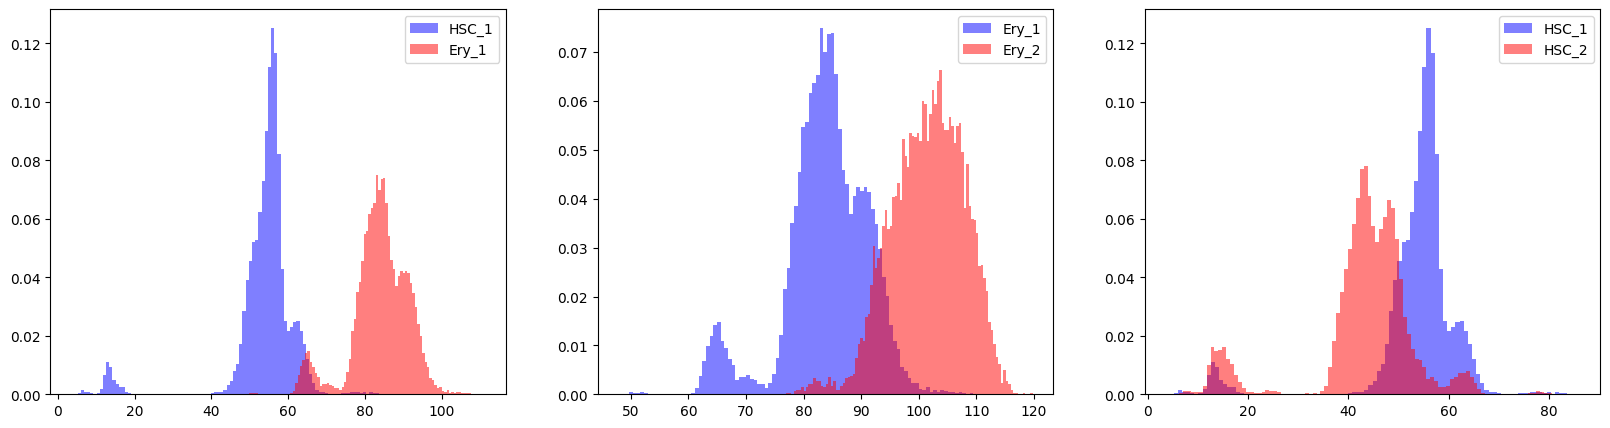

In [16]:
c2f.utils.plot_transition_posteriors(mod, adata.obs['clusters'], chosen_transitions)

To quantify these results, we calculate the percentage of cells in the second cluster that have a larger cell-specific time than the 90th percentile of times in the first cluster. A score below 0.25 indicates low confidence in the cell state transition:

In [17]:
c2f.utils.compute_transition_scores(mod, adata.obs['clusters'], chosen_transitions, percentile = 0.9)

,Transition,Score
0,"(HSC_1, Ery_1)",0.998113
1,"(Ery_1, Ery_2)",0.919497
2,"(HSC_1, HSC_2)",0.033062


Indeed, the direction of the 'HSC_1' to 'HSC_2' transition is incorrectly estimtated by cell2fate and correspondly also has a low score in this assessement.